# Constants

In [3]:
import os
import requests
import zipfile
import subprocess as sbp
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dataclasses import dataclass
from typing import List, Dict, Optional
import json
# You can place this in a utilities cell/file.
import re
from datetime import datetime, timezone
from typing import Optional, Iterable
import pandas as pd
import json
import yaml
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd # Needed for pd.Timedelta
from IPython.display import clear_output

clear_output(wait=True)
print("Cleared output successfully.")


Cleared output successfully.


In [ ]:
# change it to the path where you wanna put your data
BASE_PATH = Path("")
# BASE_PATH = Path("path_to_your_folder_of_work")

In [3]:
datasets = ["known", "composite", "generated"]

In [4]:
def get_json_files(dataset_name):
    dataset_path = BASE_PATH / dataset_name
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset path {dataset_path} does not exist.")
    json_files = list(dataset_path.glob("*.json"))
    return json_files

In [5]:
data_paths = {
    name: get_json_files(name)
    for name in datasets
}

In [6]:
for _, json_files in data_paths.items():
    print(len(json_files))

8
10
20


In [7]:
def load_json_to_df(json_file):
    df = pd.read_json(json_file, lines=True)
    src = df.pop("srcNode").apply(pd.Series).add_prefix("src_")
    dst = df.pop("dstNode").apply(pd.Series).add_prefix("dst_")
    flat_df = pd.concat([df, src, dst], axis=1)
    flat_df["datetime"] = pd.to_datetime(flat_df["timestamp"], unit="s")
    return flat_df

In [10]:
known = {
    f"C{i+1}": load_json_to_df(json_file)
    for i, json_file in tqdm(enumerate(data_paths["known"]), total=len(data_paths["known"]), desc="Loading known dataset")
}


Loading known dataset:  38%|███▊      | 3/8 [3:30:16<5:50:27, 4205.58s/it]








Loading known dataset: 100%|██████████| 8/8 [1:04:24<00:00, 483.10s/it]


In [12]:
known['C1'].shape, known['C2'].shape, known['C3'].shape, known['C4'].shape, known['C5'].shape, known['C6'].shape, known['C7'].shape, known['C8'].shape

((844723, 22),
 (155296, 22),
 (442729, 22),
 (961920, 22),
 (950436, 22),
 (1203013, 22),
 (2072151, 22),
 (607416, 22))

In [15]:
for _, df in known.items():
    print(df['label'].value_counts())

label
benign                                            844674
T1059.001_6efbccc1869e8cd618c0d3ecda407d5f            17
T1547.009_501af516bd8b24fee0c7c650ae5cc861            10
T1566.001_1afaec09315ab71fdfb167175e8a019a             9
T1547.001_1f15ab22c39a9b6bb2bb0d77276dfcb3             5
T1562.001_43e3334362b140924f001b256b229ee5             4
T1564.003_9a2edad4053a2b59fb9167a9bc29e7dc             2
T1204.002_522f3f35cd013e63830fa555495a0081             1
T1055.002_e5bcefee-262d-4568-a261-e8a20855ec81         1
Name: count, dtype: int64
label
benign                                            141172
T1005_720a3356-eee1-4015-9135-0fc08f7eb2d5         14088
T1566.001_1afaec09315ab71fdfb167175e8a019a             9
T1059.001_bfff9006-d1fb-46ce-b173-92cb04e9a031         7
T1021.001_dd67068b052fa553ad4a0ac7d6a5ea89             7
T1547.001_1f15ab22c39a9b6bb2bb0d77276dfcb3             6
T1548.002_665432a4-42e7-4ee1-af19-a9a8c9455d0c         4
T1204.002_522f3f35cd013e63830fa555495a0081        

In [16]:
# check if all dfs in known have timestamp valid
for name, df in known.items():
    if not pd.to_datetime(df['timestamp'], errors='coerce').notna().all():
        print(f"Invalid timestamps found in dataframe {name}")

In [17]:
known['C1'].columns

Index(['relation', 'timestamp', 'label', 'src_UUID', 'src_Name', 'src_Image',
       'src_Cmdline', 'src_Type', 'src_Pid', 'dst_UUID', 'dst_Name',
       'dst_Type', 'dst_Key', 'dst_Value', 'dst_Srcaddress', 'dst_Dstaddress',
       'dst_Port', 'dst_Image', 'dst_Cmdline', 'dst_Pid', 'dst_Path',
       'datetime'],
      dtype='object')

In [18]:
# Build log-style content

def make_log_df(df: pd.DataFrame, include_timestamp_in_content=True) -> pd.DataFrame:
    # Columns to combine (exclude label, and maybe timestamp)
    exclude = {'label'}
    if not include_timestamp_in_content:
        exclude.add('timestamp')
    cols = [c for c in df.columns if c not in exclude]
    
    # Preferred timestamp column (keep as integer; you can convert later)
    out = df[['timestamp','label']].copy()
    
    # For speed: convert selected columns to string only where not null
    def row_fmt(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.isna(v):
                continue
            # Use ISO for datetime column
            if c == 'datetime':
                v = pd.to_datetime(v).isoformat()
            parts.append(f"{c}={v}")
        return " ".join(parts)
    
    out['content'] = df.apply(row_fmt, axis=1)
    return out

In [21]:
_known = {
    name: None for name in known.keys()
}

In [22]:
_known['C1'] = make_log_df(known['C1'])

In [ ]:
_known['C1'].head()

,timestamp,label,content
0,2022-06-14 02:33:36,benign,relation=QueryAllInformationFile timestamp=202...
1,2022-06-14 02:33:36,benign,relation=CreateFile timestamp=2022-06-14 02:33...
2,2022-06-14 02:33:36,benign,relation=QueryAllInformationFile timestamp=202...
3,2022-06-14 02:33:36,benign,relation=CloseFile timestamp=2022-06-14 02:33:...
4,2022-06-14 02:33:36,benign,relation=CreateFile timestamp=2022-06-14 02:33...


In [ ]:
_known['C1'].to_csv("path_to_your_dataset_folder/prod/C1_log.csv", index=False)

In [25]:
_known['C2'] = make_log_df(known['C2'])

In [26]:
_known['C2'].head()

,timestamp,label,content
0,2022-06-14 23:18:51,benign,relation=RegQueryValue timestamp=2022-06-14 23...
1,2022-06-14 23:18:51,benign,relation=RegQueryValue timestamp=2022-06-14 23...
2,2022-06-14 23:18:51,benign,relation=RegQueryValue timestamp=2022-06-14 23...
3,2022-06-14 23:18:51,benign,relation=RegQueryValue timestamp=2022-06-14 23...
4,2022-06-14 23:18:51,benign,relation=RegQueryValue timestamp=2022-06-14 23...


In [ ]:
_known['C2'].to_csv("path_to_your_dataset_folder/prod/C2_log.csv", index=False)

In [28]:
_known['C3'] = make_log_df(known['C3'])

In [29]:
_known['C3'].head()

,timestamp,label,content
0,2022-06-14 04:20:05,benign,relation=RegCreateKey timestamp=2022-06-14 04:...
1,2022-06-14 04:20:05,benign,relation=RegCloseKey timestamp=2022-06-14 04:2...
2,2022-06-14 04:20:05,benign,relation=RegQueryKey timestamp=2022-06-14 04:2...
3,2022-06-14 04:20:05,benign,relation=RegOpenKey timestamp=2022-06-14 04:20...
4,2022-06-14 04:20:05,benign,relation=RegCreateKey timestamp=2022-06-14 04:...


In [ ]:
_known['C3'].to_csv("path_to_your_dataset_folder/prod/C3_log.csv", index=False)

In [31]:
_known['C4'] = make_log_df(known['C4'])
_known['C5'] = make_log_df(known['C5'])
_known['C6'] = make_log_df(known['C6'])
_known['C7'] = make_log_df(known['C7'])
_known['C8'] = make_log_df(known['C8'])

In [ ]:
_known['C4'].to_csv("path_to_your_dataset_folder/prod/C4_log.csv", index=False)
_known['C5'].to_csv("path_to_your_dataset_folder/prod/C5_log.csv", index=False)
_known['C6'].to_csv("path_to_your_dataset_folder/prod/C6_log.csv", index=False)
_known['C7'].to_csv("path_to_your_dataset_folder/prod/C7_log.csv", index=False)
_known['C8'].to_csv("path_to_your_dataset_folder/prod/C8_log.csv", index=False)

In [ ]:
# let's merge the _known dfs into one and then sorted by timestamp and then save it in prod as known.csv

merged_known = pd.concat([_known['C1'], _known['C2'], _known['C3'], _known['C4'], _known['C5'], _known['C6'], _known['C7'], _known['C8']])
merged_known = merged_known.sort_values(by='timestamp')
merged_known.to_csv("path_to_your_dataset_folder/prod/known.csv", index=False)


In [34]:
merged_known.shape

(7237684, 3)

In [35]:
merged_known['label'].value_counts()

label
benign                                            7208077
T1005_720a3356-eee1-4015-9135-0fc08f7eb2d5          28176
T1046_5a4cb2be-2684-4801-9355-3a90c91e0004           1023
T1219_7dabcbecab0334b115feefab1630f84a                100
T1566.001_1afaec09315ab71fdfb167175e8a019a             72
T1204.002_522f3f35cd013e63830fa555495a0081             52
T1071.001_24c3b7b004401d839a5c337201da3484             42
T1083_52177cc1-b9ab-4411-ac21-2eadc4b5d3b8             21
T1059.001_6efbccc1869e8cd618c0d3ecda407d5f             17
T1547.001_1f15ab22c39a9b6bb2bb0d77276dfcb3             16
T1547.009_501af516bd8b24fee0c7c650ae5cc861             10
T1059.001_bfff9006-d1fb-46ce-b173-92cb04e9a031          7
T1007_9d03c91bdae5a80f17f89c987942b5a8                  7
T1021.001_dd67068b052fa553ad4a0ac7d6a5ea89              7
T1105_0856c235a1d26113d4f2d92e39c9a9f8                  7
T1491_47d08617-5ce1-424a-8cc5-c9c978ce6bf9              6
T1567_3d3d378b0bf66f763b0c9d7a129eb130                  6
T1547.00

In [36]:
# create a new column Label in merged_known, it will be 0 if label is benign and 1 otherwise
merged_known['Label'] = merged_known['label'].apply(lambda x: 0 if x == 'benign' else 1) 

In [ ]:
# save
merged_known.to_csv("path_to_your_dataset_folder/prod/known.csv", index=False)


In [38]:
merged_known['Label'].value_counts()

Label
0    7208077
1      29607
Name: count, dtype: int64

In [39]:
merged_known.columns

Index(['timestamp', 'label', 'content', 'Label'], dtype='object')

# Import Prod version

In [ ]:
_path = "your_path_to_dataset/known.csv"

In [5]:
df = pd.read_csv(_path, low_memory=False)
df.shape

(7237684, 4)

In [6]:
df.head()

,timestamp,label,content,Label
0,2022-06-14 02:24:43,benign,relation=CreateFile timestamp=2022-06-14 02:24...,0
1,2022-06-14 02:24:43,benign,relation=CloseFile timestamp=2022-06-14 02:24:...,0
2,2022-06-14 02:24:43,benign,relation=CreateFile timestamp=2022-06-14 02:24...,0
3,2022-06-14 02:24:43,benign,relation=QueryBasicInformationFile timestamp=2...,0
4,2022-06-14 02:24:43,benign,relation=CreateFile timestamp=2022-06-14 02:24...,0


In [7]:
df['Label'].value_counts()

Label
0    7208077
1      29607
Name: count, dtype: int64

In [8]:
def clean_log_content(log_content):

    if not log_content or pd.isna(log_content):
        return log_content
        
    # Pattern 1: Long hexadecimal strings (>20 characters)
    hex_pattern = r'\b[0-9a-fA-F]{20,}\b'
    log_content = re.sub(hex_pattern, '<HEX_DATA>', log_content)

    # Pattern 2: Memory addresses (hex values with 0x prefix or typical memory patterns)
    memory_pattern = r'\b0x[0-9a-fA-F]+\b|[a-zA-Z0-9]+=0x[0-9a-fA-F]+|[a-zA-Z0-9]+=[0-9a-fA-F]{8,16}\b'
    log_content = re.sub(memory_pattern, '<MEMORY_ADDR>', log_content)

    # Pattern 3: File descriptors and handles
    fd_pattern = r'\b(?:fd|handle|descriptor)=\d+\b'
    log_content = re.sub(fd_pattern, '<FILE_DESC>', log_content)

    # Pattern 4: Process IDs, Thread IDs, and similar numeric identifiers
    pid_pattern = r'\b(?:pid|ppid|tid|uid|gid|sid)=\d+\b'
    log_content = re.sub(pid_pattern, '<PROCESS_ID>', log_content)

    # Pattern 5: Timestamps within log content
    timestamp_pattern = r'\b\d{4}-\d{2}-\d{2}[T\s]\d{2}:\d{2}:\d{2}(?:\.\d+)?(?:Z|[+-]\d{2}:\d{2})?\b'
    log_content = re.sub(timestamp_pattern, '<TIMESTAMP>', log_content)

    # Pattern 6: Long numeric sequences (often IDs or hashes)
    long_num_pattern = r'\b\d{10,}\b'
    log_content = re.sub(long_num_pattern, '<LONG_NUM>', log_content)

    # Pattern 7: IP addresses
    ip_pattern = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'
    log_content = re.sub(ip_pattern, '<IP_ADDR>', log_content)

    # Pattern 8: File paths with high variability
    path_pattern = r'(/[a-zA-Z0-9_.-]+){4,}'
    log_content = re.sub(path_pattern, '<FILE_PATH>', log_content)

    # Pattern 9: URLs and URIs
    url_pattern = r'https?://[^\s]+|[a-zA-Z][a-zA-Z0-9+.-]*://[^\s]+'
    log_content = re.sub(url_pattern, '<URL>', log_content)

    # Pattern 10: Email addresses
    email_pattern = r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b'
    log_content = re.sub(email_pattern, '<EMAIL>', log_content)

    # Pattern 11: Clean up multiple consecutive spaces and normalize whitespace
    log_content = re.sub(r'\s+', ' ', log_content)

    # Pattern 12: Remove empty brackets and parentheses left after cleaning
    log_content = re.sub(r'\[\s*\]|\(\s*\)', '', log_content)

    return log_content.strip()

In [9]:
df['Content'] = df['content'].apply(clean_log_content)

In [10]:
df.head()

,timestamp,label,content,Label,Content
0,2022-06-14 02:24:43,benign,relation=CreateFile timestamp=2022-06-14 02:24...,0,relation=CreateFile timestamp=<TIMESTAMP> src_...
1,2022-06-14 02:24:43,benign,relation=CloseFile timestamp=2022-06-14 02:24:...,0,relation=CloseFile timestamp=<TIMESTAMP> src_<...
2,2022-06-14 02:24:43,benign,relation=CreateFile timestamp=2022-06-14 02:24...,0,relation=CreateFile timestamp=<TIMESTAMP> src_...
3,2022-06-14 02:24:43,benign,relation=QueryBasicInformationFile timestamp=2...,0,relation=QueryBasicInformationFile timestamp=<...
4,2022-06-14 02:24:43,benign,relation=CreateFile timestamp=2022-06-14 02:24...,0,relation=CreateFile timestamp=<TIMESTAMP> src_...


In [ ]:
df.to_csv('path_to/known8.csv', index=False)

In [ ]:
_path = "path_to/C8_log.csv"

In [69]:
df2 = pd.read_csv(_path, low_memory=False)
df2.shape

(607416, 3)

In [70]:
df2.head()

,timestamp,label,content
0,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...
1,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...
2,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...
3,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...
4,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...


In [71]:
df2['Label'] = df2['label'].apply(lambda x: 0 if x == 'benign' else 1)

In [72]:
df2['Content'] = df2['content'].apply(clean_log_content)

In [73]:
df2.head()

,timestamp,label,content,Label,Content
0,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...,0,relation=RegQueryValue timestamp=<TIMESTAMP> s...
1,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...,0,relation=RegQueryValue timestamp=<TIMESTAMP> s...
2,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...,0,relation=RegQueryValue timestamp=<TIMESTAMP> s...
3,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...,0,relation=RegQueryValue timestamp=<TIMESTAMP> s...
4,2022-06-14 04:09:05,benign,relation=RegQueryValue timestamp=2022-06-14 04...,0,relation=RegQueryValue timestamp=<TIMESTAMP> s...


In [74]:
df2['Label'].value_counts()

Label
0    607386
1        30
Name: count, dtype: int64

In [ ]:
df2.to_csv("path_to/known_c8.csv", index=False)

# Analysis

In [76]:
_FONT_SIZE = 24
_FS = 22

In [77]:
# from 1 to 8
datasets = [i for i in range(1, 9)]


In [ ]:
BASE_PATH = Path(".../prod/known")

In [84]:
def load_prod(dataset_name, cols=None):
    file_path = BASE_PATH / f"known_c{dataset_name}.csv"
    df = pd.read_csv(file_path, low_memory=False)
    if cols:
        df = df[cols]
    return df

In [89]:
data = {
    f"C{name}": load_prod(name, ["Label"]) for name in datasets
}

In [90]:
counts = {
    name: {"Total": len(df), "Normal": df[df['Label'] == 0].shape[0], "Anomalous": df[df['Label'] == 1].shape[0]}
    for name, df in data.items()
}

<ipython-input-91-6d1ffea64965>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=_FS)


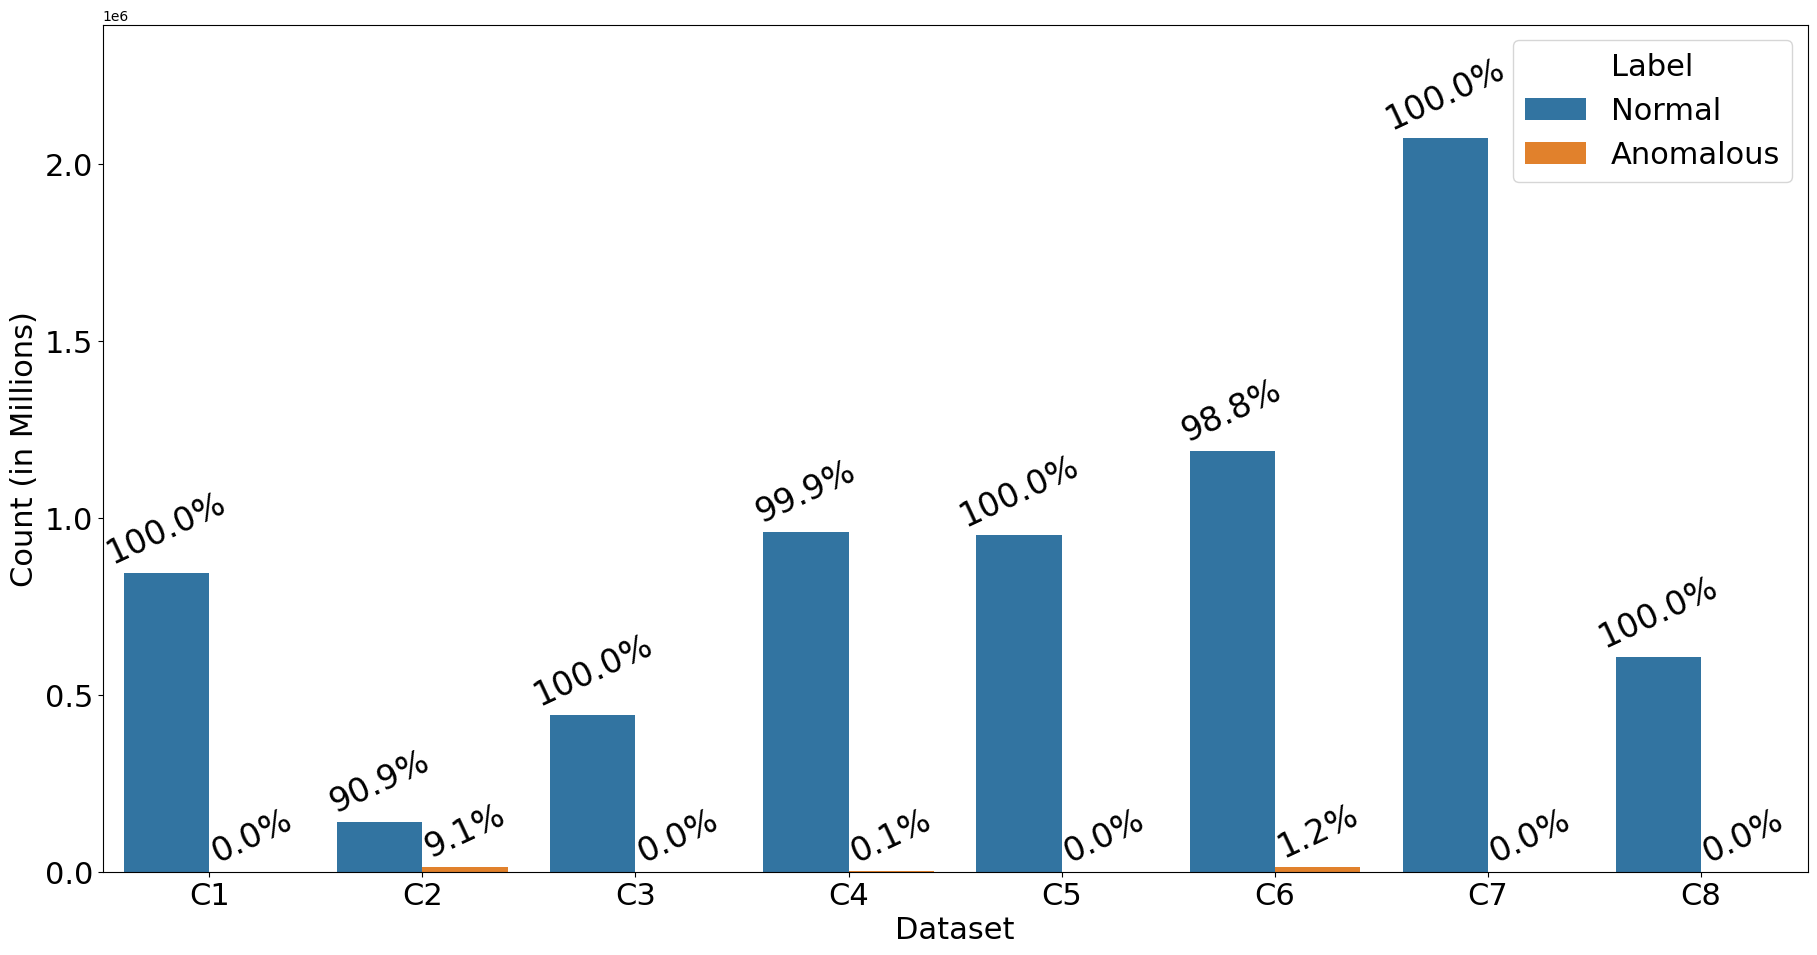

In [91]:
#Convert the dictionary to a DataFrame and reset the index
df = pd.DataFrame(counts).T.reset_index()
df = df.rename(columns={"index": "Dataset"})

# Melt the DataFrame to a long format suitable for Seaborn
# This creates separate rows for 'Normal' and 'Anomalous' counts
df_melted = df.melt(id_vars="Dataset", value_vars=["Normal", "Anomalous"],
                    var_name="Label", value_name="Count")

# --- New section to calculate percentages ---
# Create a dictionary mapping each Dataset to its Total count
total_counts = df.set_index('Dataset')['Total'].to_dict()

# Calculate the percentage for each row in the melted DataFrame
# The percentage is (Count / Total for that Dataset) * 100
df_melted['Percentage'] = df_melted.apply(
    lambda row: (row['Count'] / total_counts[row['Dataset']]) * 100,
    axis=1
)
# --- End of new section ---

# Set the figure size for better readability
plt.style.use('default')
plt.figure(figsize=(22, 11))

# Create the bar plot and store the Axes object
ax = sns.barplot(data=df_melted, x="Dataset", y="Count", hue="Label")

# Add the percentage labels on top of each bar
# ax.containers holds the groups of bars (one group for 'Normal', one for 'Anomalous')
for i, container in enumerate(ax.containers):
    # Get the correct percentage values for the current container (hue)
    # The order of hue is determined by the `value_vars` list in `melt`
    hue_label = ["Normal", "Anomalous"][i]
    labels = [f'{p:.1f}%' for p in df_melted[df_melted['Label'] == hue_label]['Percentage']]
    
    # Attach the labels to the bars in the container
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=_FONT_SIZE, padding=2, rotation=25)
    

# Adjust the y-axis limit to give more space for the labels
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=_FS)
ax.get_yaxis().set_tick_params(labelsize=_FS)



# Add titles and labels for clarity
# plt.title("Counts of Normal and Anomalous Labels per Dataset with Percentages")
plt.xlabel("Dataset", fontsize=_FS)
plt.ylabel("Count (in Millions)", fontsize=_FS)
plt.legend(title="Label", fontsize=_FS, title_fontsize=_FS)

# Display the plot
plt.show()